## Import Library

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

import joblib

## Data Loading

In [2]:
dataset = pd.read_csv("data/obesity_data.csv")
dataset = dataset.drop(columns=["BMI"])

dataset

,Age,Gender,Height,Weight,PhysicalActivityLevel,ObesityCategory
0,56,Male,173.575262,71.982051,4,Normal weight
1,69,Male,164.127306,89.959256,2,Obese
2,46,Female,168.072202,72.930629,4,Overweight
3,32,Male,168.459633,84.886912,3,Overweight
4,60,Male,183.568568,69.038945,3,Normal weight
...,...,...,...,...,...,...
995,18,Male,155.588674,64.103182,4,Overweight
996,35,Female,165.076490,97.639771,1,Obese
997,49,Female,156.570956,78.804284,1,Obese
998,64,Male,164.192222,57.978115,4,Normal weight


**Insight:**  
Fitur BMI dihapus dari dataset karena BMI merupakan representasi dari tinggi dan berat badan. Penghapusan ini bertujuan untuk mengurangi redundasi pada dataset sehingga dapat menghindari overfitting.

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    1000 non-null   int64  
 1   Gender                 1000 non-null   object 
 2   Height                 1000 non-null   float64
 3   Weight                 1000 non-null   float64
 4   PhysicalActivityLevel  1000 non-null   int64  
 5   ObesityCategory        1000 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 47.0+ KB


**Insight:**  
Dataset terdiri dari 1000 observasi, 6 fitur sebagai prediktor, dan 1 target.

## Data Understanding

### Pengecekan Missing Value

In [4]:
dataset.isna().sum()

Age                      0
Gender                   0
Height                   0
Weight                   0
PhysicalActivityLevel    0
ObesityCategory          0
dtype: int64

**Insight:**  
Tidak ada missing value pada dataset.

### Pengecekan Duplikasi Data

In [5]:
print(dataset[dataset.duplicated()])

Empty DataFrame
Columns: [Age, Gender, Height, Weight, PhysicalActivityLevel, ObesityCategory]
Index: []


**Insight:**  
Tidak ada observasi duplikat pada dataset.

### Ringkasan Statistik

In [6]:
dataset.describe(include="all")

,Age,Gender,Height,Weight,PhysicalActivityLevel,ObesityCategory
count,1000.000000,1000,1000.000000,1000.000000,1000.000000,1000
unique,NaN,2,NaN,NaN,NaN,4
top,NaN,Male,NaN,NaN,NaN,Normal weight
freq,NaN,523,NaN,NaN,NaN,371
mean,49.857000,NaN,170.052417,71.205769,2.534000,NaN
std,18.114267,NaN,10.309971,15.509849,1.116284,NaN
min,18.000000,NaN,136.115719,26.065730,1.000000,NaN
25%,35.000000,NaN,163.514205,61.129629,2.000000,NaN
50%,50.000000,NaN,169.801665,71.929072,3.000000,NaN
75%,66.000000,NaN,177.353596,81.133746,4.000000,NaN


**Insight:**  
Berdasarkan ringkasan statistik, fitur numerik memiliki sebaran yang berbeda-beda dan tidak terlihat nilai yang terlalu ekstrem.

### Visualisasi Data

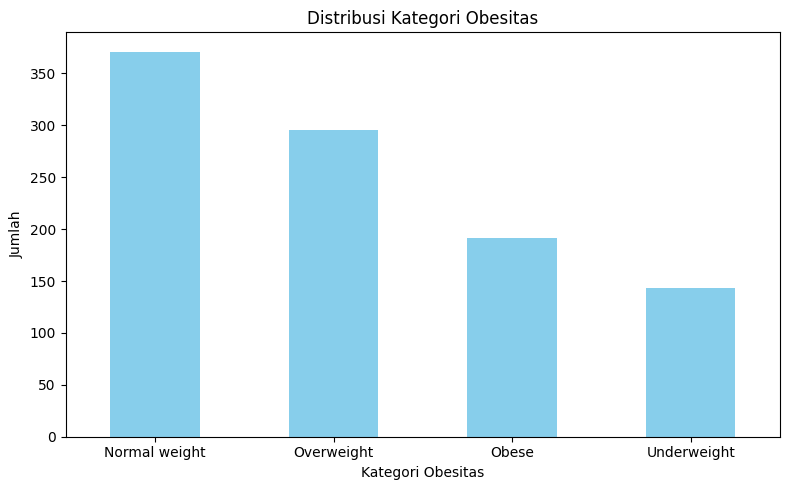

In [7]:
obesity = dataset["ObesityCategory"].value_counts()

plt.figure(figsize=(8, 5))
obesity.plot(kind='bar', color='skyblue')

plt.title('Distribusi Kategori Obesitas')
plt.xlabel('Kategori Obesitas')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

**Insight:**  
Setiap kategori obesitas memiliki frekuensi yang berbeda-beda. Kategori "normal weight" memiliki frekuensi paling banyak, sedangkan kategori "underweight" memiliki frekuensi paling sedikit. Kondisi ini harus dipertimbangkan untuk melatih model karena distribusi kelas yang tidak seragam sehingga dapat memengaruhi performa model.

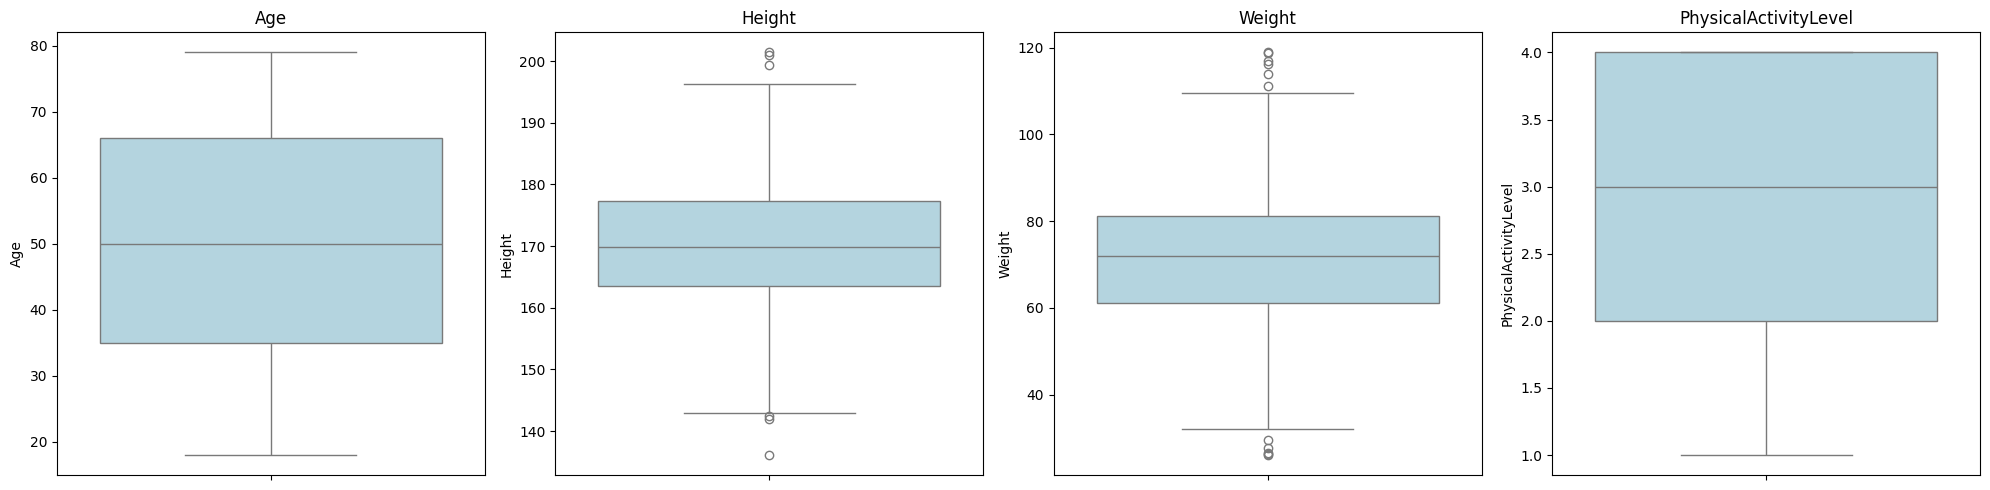

In [8]:
# Ambil hanya kolom numerik
numerik_df = dataset.select_dtypes(include='number')

num_features = numerik_df.columns
n = len(num_features)

# Subplot otomatis per baris
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(5 * n, 5))
for i, col in enumerate(num_features):
    sns.boxplot(y=numerik_df[col], ax=axes[i], color='lightblue')
    axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()

**Insight:**  
Boxplot menunjukkan data cenderung berdistribusi simteris. Akan tetapi, fitur "Weight" terdapat beberapa pencilan di bagian atas.

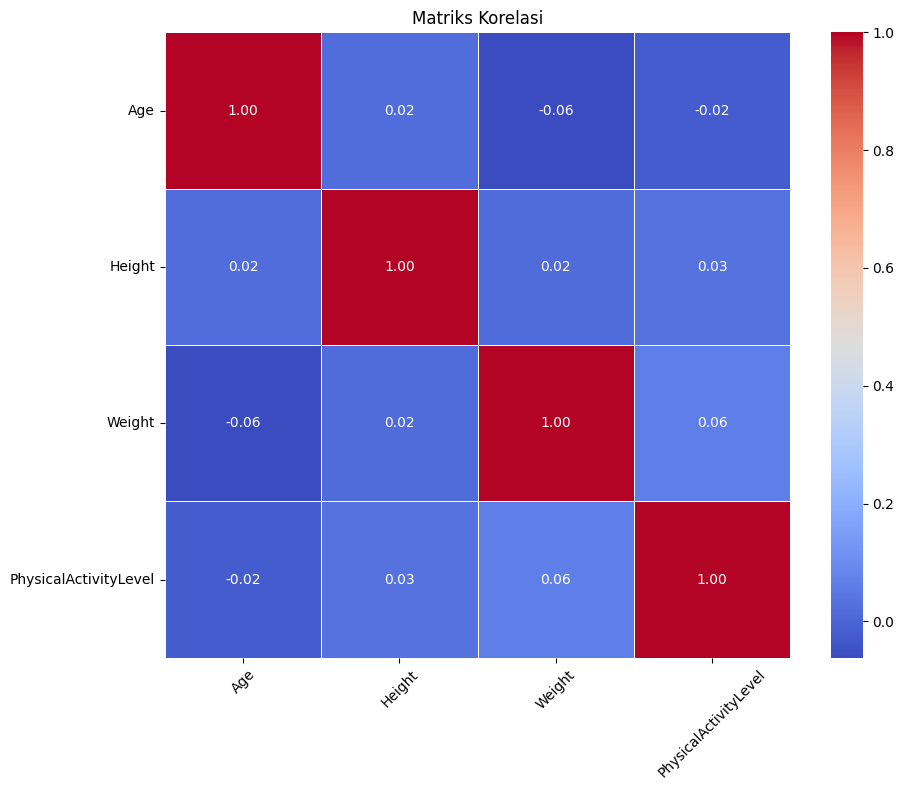

In [9]:
# Hitung matriks korelasi
korelasi = numerik_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(korelasi, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)

plt.title('Matriks Korelasi')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Insight:**  
Fitur numerik pada dataset memiliki korelasi lemah yang menandakan semua fitur dapat digunakan untuk pembuatan model.

## Data Preparation

### Data Preprocessing

#### Encoding Fitur Kategorik

In [10]:
df_clean = dataset.copy()
gender_encoder = LabelEncoder()
obesity_encoder = LabelEncoder()

df_clean["Gender"] = gender_encoder.fit_transform(df_clean["Gender"])
df_clean["ObesityCategory"] = obesity_encoder.fit_transform(df_clean["ObesityCategory"])

df_clean.head()

,Age,Gender,Height,Weight,PhysicalActivityLevel,ObesityCategory
0,56,1,173.575262,71.982051,4,0
1,69,1,164.127306,89.959256,2,1
2,46,0,168.072202,72.930629,4,2
3,32,1,168.459633,84.886912,3,2
4,60,1,183.568568,69.038945,3,0


#### Data Splitting

In [11]:
X = df_clean.drop(columns="ObesityCategory")
Y = df_clean[["ObesityCategory"]]

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

### Standardisasi Fitur Numerik

#### Data Training

In [13]:
# Inisialisasi scaler
scaler = StandardScaler()
numerical_features = ["Age", "Height", "Weight"]
categorical_features = ["Gender", "PhysicalActivityLevel"]
X_train_temp = X_train.copy()

# Fit dan transform data training
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_temp[numerical_features]),
    columns=numerical_features,
    index=X_train_temp.index
)
X_train_cat = X_train_temp[categorical_features]
X_train = pd.concat([X_train_scaled, X_train_cat], axis=1)

In [14]:
# Transform fitur numerik test
X_test_num_scaled = pd.DataFrame(
    scaler.transform(X_test[numerical_features]),
    columns=numerical_features,
    index=X_test.index
)

# Ambil fitur kategorik test
X_test_cat = X_test[categorical_features].reset_index(drop=True)

# Gabungkan kembali test
X_test = pd.concat([X_test_num_scaled.reset_index(drop=True), X_test_cat], axis=1)

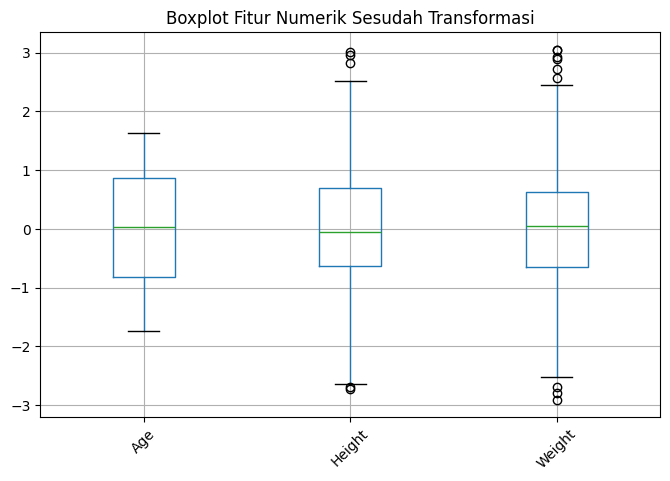

In [15]:
plt.figure(figsize=(8, 5))
X_train[numerical_features].boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot Fitur Numerik Sesudah Transformasi")
plt.show()

**Insight:**  
Setelah standardisasi data, setiap fitur numerik telah memiliki sebaran yang seragam satu sama lain.

## Modelling

### Sebelum Penerapan SMOTE

#### 1. Random Forest

In [16]:
rf = RandomForestClassifier(random_state=42)

##### Hyperparameter Tuning dengan Random Search

In [17]:
param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [18]:
random_search_rf.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024E43F4EBB0>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024E43F4E940>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024E43F474C0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024E43CB0640>},
                   random_state=42, scoring='accuracy', verbose=2)

In [19]:
best_rf = random_search_rf.best_estimator_
print("Best parameters:", random_search_rf.best_params_)

Best parameters: {'bootstrap': True, 'max_depth': 31, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 154}


In [20]:
best_rf.fit(X_train, Y_train)

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=31, max_features=None, min_samples_leaf=3,
                       min_samples_split=5, n_estimators=154, random_state=42)

##### Penerapan 5-Cross Validation

In [21]:
rf_scores = cross_val_score(best_rf, X_train, Y_train, cv=5, scoring='accuracy')

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

In [22]:
print("Akurasi per fold:", rf_scores)
print("Rata-rata akurasi:", rf_scores.mean())

Akurasi per fold: [0.95   0.9125 0.925  0.9375 0.95  ]
Rata-rata akurasi: 0.9349999999999999


**Insight:**  
Hasil 5-Cross Validation menunjukkan bahwa akurasi model sudah baik setiap fold.

#### 2. Support Vector Machine (SVM)

In [23]:
svm = SVC(random_state=42)

##### Hyperparameter Tuning dengan Random Search

In [24]:
param_dist_svm = {
    'C': uniform(0.1, 10),
    'gamma': uniform(0.001, 1),
    'kernel': ['rbf', 'linear']
}

random_search_svm = RandomizedSearchCV(
    svm,
    param_distributions=param_dist_svm,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42
)

In [25]:
random_search_svm.fit(X_train, Y_train)

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was e

RandomizedSearchCV(cv=5, estimator=SVC(random_state=42), n_iter=20,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024E43DBBB50>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024E41691B20>,
                                        'kernel': ['rbf', 'linear']},
                   random_state=42, scoring='accuracy')

In [26]:
best_svm = random_search_svm.best_estimator_
print("Best parameters:", random_search_svm.best_params_)

Best parameters: {'C': 6.218528947223795, 'gamma': 0.14049386065204184, 'kernel': 'linear'}


In [27]:
best_svm.fit(X_train, Y_train)

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=6.218528947223795, gamma=0.14049386065204184, kernel='linear',
    random_state=42)

##### Penerapan 5-Cross Validation

In [28]:
svm_scores = cross_val_score(best_svm, X_train, Y_train, cv=5, scoring='accuracy')

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was e

In [29]:
print("Akurasi per fold:", svm_scores)
print("Rata-rata akurasi:", svm_scores.mean())

Akurasi per fold: [0.975   0.95625 0.98125 0.96875 0.95625]
Rata-rata akurasi: 0.9674999999999999


**Insight:**  
Hasil 5-cross validation menunjukkan hasil yang lebih baik dibandingkan model random forest.

### Setelah Penerapan SMOTE

In [30]:
smote = SMOTE(random_state=42)
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


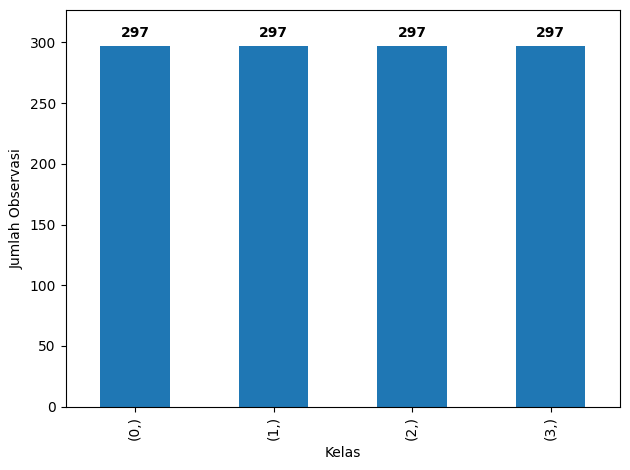

In [31]:
# Hitung jumlah masing-masing kelas
value_counts = Y_train_smote.value_counts()

# Plot bar chart
ax = value_counts.plot(kind='bar',)
plt.xlabel('Kelas')
plt.ylabel('Jumlah Observasi')
plt.ylim(0, value_counts.max() * 1.1)

# Tambahkan label masing-masing kelas
for i, v in enumerate(value_counts):
    ax.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [32]:
print(f"Training set shape: X_train_smote={X_train_smote.shape}, Y_train_smote={Y_train_smote.shape}")
print(f"Test set shape: X_test={X_test.shape}, Y_test={Y_test.shape}")

Training set shape: X_train_smote=(1188, 5), Y_train_smote=(1188, 1)
Test set shape: X_test=(200, 5), Y_test=(200, 1)


**Insight:**  
Setelah implementasi SMOTE, distribusi kelas menjadi seimbang dan sudah siap untuk modelling.

#### 1. Random Forest

In [33]:
rf_smote = RandomForestClassifier(random_state=42)

##### Hyperparameter Tuning dengan Random Search

In [34]:
random_search_rf_smote = RandomizedSearchCV(
    estimator=rf_smote,
    param_distributions=param_dist_rf,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [35]:
random_search_rf_smote.fit(X_train_smote, Y_train_smote)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024E43F4EBB0>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024E43F4E940>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024E43F474C0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024E43CB0640>},
                   random_state=42, scoring='accuracy', verbose=2)

In [36]:
best_rf_smote = random_search_rf_smote.best_estimator_
print("Best parameters:", random_search_rf_smote.best_params_)

Best parameters: {'bootstrap': True, 'max_depth': 48, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 491}


In [37]:
best_rf_smote.fit(X_train_smote, Y_train_smote)

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=48, max_features=None, min_samples_leaf=3,
                       n_estimators=491, random_state=42)

##### Penerapan 5-Cross Validation

In [38]:
rf_smote_scores = cross_val_score(best_rf_smote, X_train_smote, Y_train_smote, cv=5, scoring='accuracy')

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

In [39]:
print("Akurasi per fold:", rf_smote_scores)
print("Rata-rata akurasi:", rf_smote_scores.mean())

Akurasi per fold: [0.95798319 0.95378151 0.94537815 0.96624473 0.97468354]
Rata-rata akurasi: 0.9596142254370102


**Insight:**  
Akurasi model random forest mengalami peningkatan setelah penerapan SMOTE. Hal ini menunjukkan bahwa distribusi kelas yang seimbang dapat meningkatkan performa model.

#### 2. SVM

In [40]:
svm_smote = SVC(random_state=42)

##### Hyperparameter Tuning dengan Random Search

In [41]:
random_search_svm_smote = RandomizedSearchCV(
    svm_smote,
    param_distributions=param_dist_svm,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42
)

In [42]:
random_search_svm_smote.fit(X_train_smote, Y_train_smote)

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was e

RandomizedSearchCV(cv=5, estimator=SVC(random_state=42), n_iter=20,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024E43DBBB50>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024E41691B20>,
                                        'kernel': ['rbf', 'linear']},
                   random_state=42, scoring='accuracy')

In [43]:
best_svm_smote = random_search_svm_smote.best_estimator_
print("Best parameters:", random_search_svm_smote.best_params_)

Best parameters: {'C': 9.83755518841459, 'gamma': 0.23377134043030423, 'kernel': 'linear'}


In [44]:
best_svm_smote.fit(X_train_smote, Y_train_smote)

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=9.83755518841459, gamma=0.23377134043030423, kernel='linear',
    random_state=42)

##### Penerapan 5-Cross Validation

In [45]:
svm_smote_scores = cross_val_score(best_svm_smote, X_train_smote, Y_train_smote, cv=5, scoring='accuracy')

c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hp14s\anaconda3\envs\main-ds\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was e

In [46]:
print("Akurasi per fold:", svm_smote_scores)
print("Rata-rata akurasi:", svm_smote_scores.mean())

Akurasi per fold: [0.97058824 0.98739496 0.99159664 0.99578059 0.97468354]
Rata-rata akurasi: 0.9840087933907741


**Insight:**  
Akurasi model SVM mengalami peningkatan hampir sempurna setelah penerapan SMOTE. Hal ini menunjukkan bahwa distribusi kelas yang seimbang dapat meningkatkan performa model.

### Pemilihan Model Terbaik  
Berdasarkan evaluasi dengan 4 metrik klasifikasi, model Random Forest dengan penerapan SMOTE dipilih sebagai model terbaik karena memiliki akurasi sempurna pada data testing. Penerapan SMOTE akan membantu model dalam memahami pola setiap kelas yang tidak seimbang sehingga model dapat memprediksi dengan baik pada production use.

## Evaluation

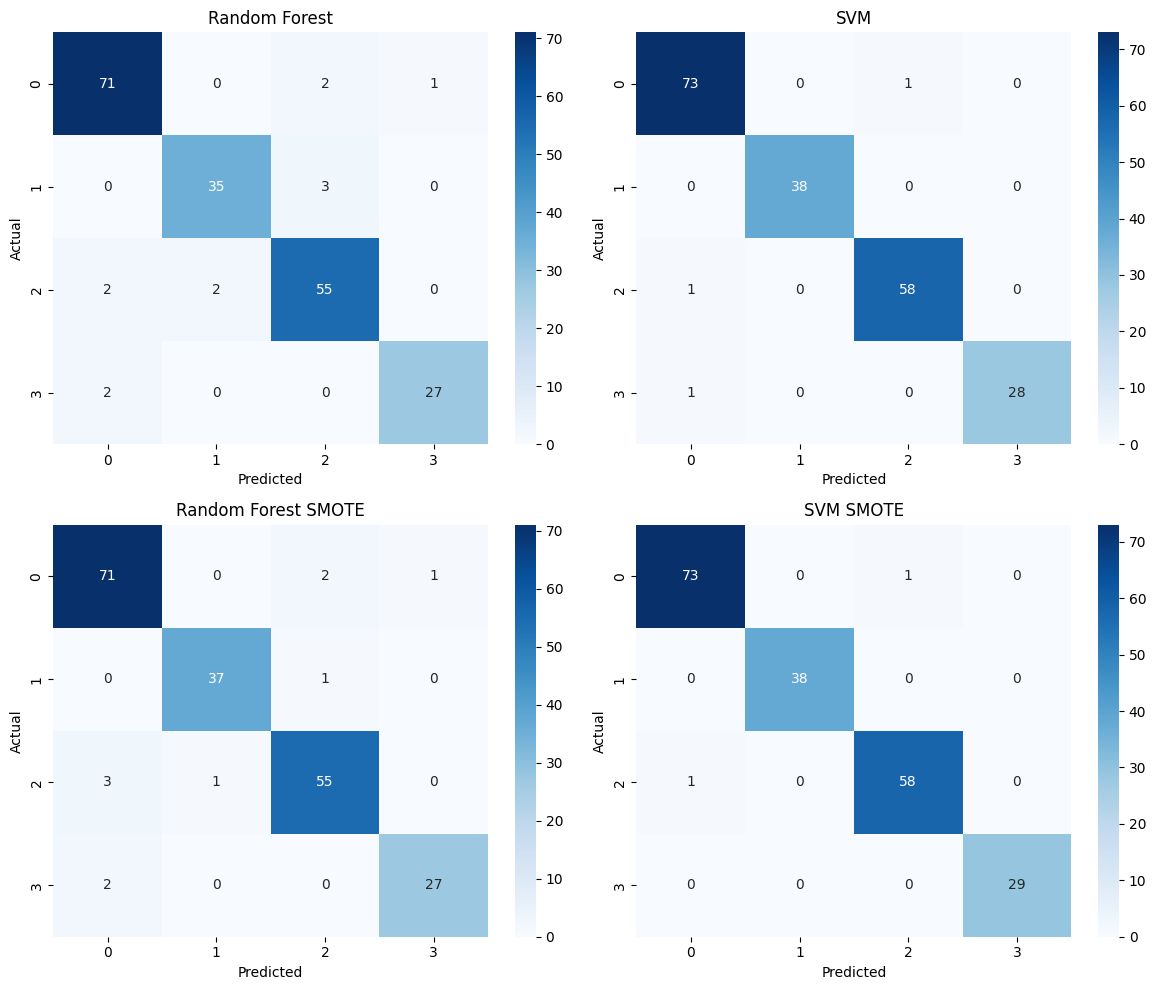

In [47]:
def plot_confusion_matrices(models, names, X_test, Y_test):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, (model, name) in enumerate(zip(models, names)):
        Y_pred = model.predict(X_test)
        cm = confusion_matrix(Y_test, Y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(name)
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

models = [best_rf, best_svm, best_rf_smote, best_svm_smote]
names = [
    "Random Forest",
    "SVM",
    "Random Forest SMOTE",
    "SVM SMOTE"
]

# Panggil fungsi
plot_confusion_matrices(models, names, X_test, Y_test)

**Insight:**  
- Confusion matrix menunjukkan bahwa model random forest sebelum penerapan SMOTE banyak mengalami salah prediksi. Model SVM sebelum SMOTE sudah cukup baik dalam memprediksi, tetapi masih terdapat kesalahan pada beberapa kelas.
- Setelah penerapan SMOTE, model random forest lebih baik dalam memprediksi, sedangkan model SVM hanya salah memprediksi pada 2 observasi saja.


In [48]:
# Fungsi untuk mengevaluasi dan mengembalikan hasil sebagai dictionary
def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    cm = confusion_matrix(Y_test, Y_pred)
    results = {
        'Confusion Matrix': cm,
        'Accuracy': accuracy_score(Y_test, Y_pred),
        'Precision': precision_score(Y_test, Y_pred, average="weighted"),
        'Recall': recall_score(Y_test, Y_pred, average="weighted"),
        'F1-Score': f1_score(Y_test, Y_pred, average="weighted")
    }
    return results
 
# Mengevaluasi setiap model dan mengumpulkan hasilnya
results = {
    'Random Forest': evaluate_model(best_rf, X_test, Y_test),
    'SVM': evaluate_model(best_svm, X_test, Y_test),
    'Random Forest SMOTE': evaluate_model(best_rf_smote, X_test, Y_test),
    'SVM SMOTE': evaluate_model(best_svm_smote, X_test, Y_test)
}
 
# Buat DataFrame untuk meringkas hasil
summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
 
# Isi DataFrame dengan hasil
rows = []
for model_name, metrics in results.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    })
 
# Convert ke DataFrame
summary_df = pd.DataFrame(rows)
 
# Tampilkan DataFrame
print(summary_df)

                 Model  Accuracy  Precision  Recall  F1-Score
0        Random Forest     0.940   0.940234   0.940  0.940008
1                  SVM     0.985   0.985133   0.985  0.985006
2  Random Forest SMOTE     0.950   0.950221   0.950  0.949986
3            SVM SMOTE     0.990   0.990000   0.990  0.990000


**Insight:**
- Hasil evaluasi menunjukkan bahwa penerapan SMOTE dapat meningkatkan kemampuan model dalam klasifikasi.
- Model SVM memiliki performa yang lebih baik dibandingkan random forest, baik sebelum dan setelah penerapan SMOTE. Hal ini menunjukkan SVM lebih baik dalam mengklasifikasikan obesitas.
- Model terbaik yang dipilih saat modeling, yaitu SVM dengan SMOTE memiliki akurasi sebesar 0,990 pada data *testing*, artinya model hampir sempurna dalam mengklasifikasika obesitas.
- Model yang dibangun pada proyek ini telah memiliki performa yang sangat baik dan siap digunakan untuk *deployment* dengan membuat web prediksi.

In [49]:
# Simpan label encoder
joblib.dump(gender_encoder, "model/gender_encoder.pkl")
joblib.dump(obesity_encoder, "model/obesity_encoder.pkl")

# Simpan scaler
joblib.dump(scaler, "model/scaler.pkl")

# Simpan model yang telah dilatih
joblib.dump(best_rf_smote, "model/random_forest.joblib")

['model/random_forest.joblib']

**Insight:**  
Model sudah disimpan ke dalam format joblib dan siap digunakan untuk deployment.